In [21]:
import requests
import os
import json
import time
import pandas as pd
import pprint
pp = pprint.PrettyPrinter(indent=5)

from datetime import datetime
from pathlib import Path
from collections import Counter

input_search_string = 'ppara'
output_search_string = 'liver fibrosis'
robokopkg_bolt_url = "bolt://robokopkg.renci.org:7687"

In [18]:
# Initializing directory to write
now = datetime.now()
dt_string = now.strftime("%Y-%m-%d_%H%M%S")

write_dir_cypher_robokopkg_missing = Path("output/compare/"+str(dt_string)+"/cypher/robokopkg_missing")
write_dir_cypher_robokopkg_missing.mkdir(parents=True, exist_ok=True)

write_dir_compare = Path("output/compare/"+str(dt_string))
write_dir_compare.mkdir(parents=True, exist_ok=True)

Cypher_ROBOKOPKG_missing_results_file = "output/compare/"+str(dt_string)+"/cypher/robokopkg_missing/results.csv"

In [28]:
ARA_results_file = "output/compare/2023-07-07_153233/trapi/ara/results_ARA.csv"

In [2]:
# Pathway results to load and write directory to specify (on David's work computer from previous run)
write_dir_cypher_automat = "output/compare/2023-07-07_153233/cypher/automat"
write_dir_cypher_robokopkg = "output/compare/2023-07-07_153233/cypher/robokopkg"
ARA_results_file = "output/compare/2023-07-07_153233/trapi/ara/results_ARA.csv"
TRAPI_results_file = "output/compare/2023-07-07_153233/trapi/automat/results_TRAPI.csv"
Cypher_ROBOKOPKG_results_file = "output/compare/2023-07-07_153233/cypher/robokopkg/results.csv"
Cypher_Automat_results_file = "output/compare/2023-07-07_153233/cypher/automat/results.csv"
write_dir_compare = "output/compare/2023-07-07_153233"
exemplar_results_file = "output/compare/2023-07-07_153233/exemplar_data.csv"
qbuilder_bio_entity_results_file = "output/compare/2023-07-07_153233/qbuilder_bio_entity_data.csv"
qbuilder_blank_results_file = "output/compare/2023-07-07_153233/qbuilder_blank_data.csv"
ARA_PPARA_Fibrosis_results_file = "output/compare/2023-07-07_153233/results_ARA_PPARA_Fibrosis.csv"

In [15]:
# Initializing Neo4j connection class
user = 'neo4j'
pw = ''

from neo4j import GraphDatabase
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [7]:
results = requests.post(f'https://name-resolution-sri.renci.org/lookup?string={input_search_string}&offset=0&limit=100')
# print(results)
results_json = results.json()
print(json.dumps(results_json,indent=4))
input_node_id_list = list(results_json.keys())
print(input_node_id_list)
print(f"Number of 'input' IDs: {len(input_node_id_list)}")

<Response [500]>


In [8]:
input_node_id_list = ['MESH:C000630914', 'MESH:C000634429', 'NCBIGene:10891', 'NCBIGene:133522', 'NCBIGene:19013', 'NCBIGene:25747', 'NCBIGene:30755', 'NCBIGene:400931', 'NCBIGene:5465',
'NCBIGene:557714', 'NCBIGene:563298', 'NCBIGene:80205', 'PR:000013056', 'PR:000040325', 'REACT:R-BTA-400143', 'REACT:R-BTA-400183', 'REACT:R-BTA-400204', 'REACT:R-BTA-400206',
'REACT:R-BTA-4341070', 'REACT:R-BTA-9734475', 'REACT:R-CEL-4341070', 'REACT:R-CFA-400143', 'REACT:R-CFA-400183', 'REACT:R-CFA-400204', 'REACT:R-CFA-400206', 'REACT:R-CFA-9734475',
'REACT:R-DME-400143', 'REACT:R-DME-400183', 'REACT:R-DME-400204', 'REACT:R-DME-400206', 'REACT:R-DME-9734475', 'REACT:R-DRE-400143', 'REACT:R-DRE-400183', 'REACT:R-DRE-400204',
'REACT:R-DRE-400206', 'REACT:R-DRE-4341070', 'REACT:R-DRE-9734475', 'REACT:R-GGA-400143', 'REACT:R-GGA-4341070', 'REACT:R-HSA-1989781', 'REACT:R-HSA-400143', 'REACT:R-HSA-400183', 
'REACT:R-HSA-400204', 'REACT:R-HSA-400206', 'REACT:R-HSA-4341070', 'REACT:R-HSA-5663156', 'REACT:R-HSA-879724', 'REACT:R-HSA-9734475', 'REACT:R-MMU-400143', 'REACT:R-MMU-400183',
'REACT:R-MMU-400204', 'REACT:R-MMU-400206', 'REACT:R-MMU-4341070', 'REACT:R-MMU-9734475', 'REACT:R-RNO-400143', 'REACT:R-RNO-400183', 'REACT:R-RNO-400204', 'REACT:R-RNO-400206',
'REACT:R-RNO-4341070', 'REACT:R-RNO-9734475', 'REACT:R-SSC-400183', 'REACT:R-SSC-400204', 'REACT:R-SSC-400206', 'REACT:R-SSC-9734475', 'REACT:R-XTR-400204', 'REACT:R-XTR-400206',
'REACT:R-XTR-4341070', 'REACT:R-XTR-9734475', 'UMLS:C0166415', 'UMLS:C1518805', 'UMLS:C1868415', 'UMLS:C2984537', 'UMLS:C5197094', 'UMLS:C5226508', 'UMLS:C5417797', 'UMLS:C5575466',
'UniProtKB:P23204', 'UniProtKB:P37230', 'UniProtKB:Q07869', 'UniProtKB:Q95N78']

In [4]:
results = requests.post(f'https://name-resolution-sri.renci.org/lookup?string={output_search_string}&offset=0&limit=100')
results_json = results.json()
#print(json.dumps(results_json,indent=4))
output_node_id_list = list(results_json.keys())
print(output_node_id_list)
print(f"Number of 'output' IDs: {len(output_node_id_list)}")

['HP:0001395', 'UMLS:C4227681', 'UMLS:C4034373', 'UMLS:C5189427', 'UMLS:C0544816', 'MONDO:0100430', 'MONDO:0018840', 'UMLS:C1397317', 'UMLS:C4068302', 'UMLS:C4481250', 'UMLS:C2827436', 'UMLS:C4321337', 'UMLS:C4695229', 'UMLS:C0494791', 'UMLS:C0400961', 'UMLS:C3864238', 'UMLS:C1960658', 'UMLS:C4695228', 'UMLS:C5563662', 'UMLS:C1407032', 'UMLS:C0400925', 'UMLS:C4749320', 'UMLS:C5548949', 'UMLS:C4533463', 'UMLS:C5689517', 'UMLS:C5689516', 'UMLS:C4722044', 'UMLS:C1856310', 'UMLS:C5439238', 'UMLS:C4722043', 'UMLS:C5548946', 'UMLS:C4533767', 'UMLS:C3277942', 'UMLS:C1385044', 'UMLS:C4070891', 'UMLS:C3873179', 'UMLS:C4070890', 'UMLS:C1954436', 'UMLS:C4070622', 'UMLS:C4036765', 'UMLS:C5215514', 'UMLS:C0451713', 'UMLS:C5686432', 'UMLS:C3275636', 'UMLS:C4750548', 'UMLS:C5549445', 'UMLS:C5549441', 'UMLS:C2184113', 'UMLS:C5190480', 'UMLS:C5171263', 'UMLS:C5171261', 'UMLS:C5171262', 'UMLS:C2751577', 'UMLS:C1869017', 'UMLS:C4030819', 'UMLS:C2749679', 'UMLS:C5697513', 'UMLS:C4732266', 'UMLS:C3869480',

In [9]:
output_node_id_list = ['HP:0001395', 'UMLS:C4227681', 'UMLS:C4034373', 'UMLS:C5189427', 'UMLS:C0544816', 'MONDO:0100430', 'MONDO:0018840', 'UMLS:C1397317',
                       'UMLS:C4068302', 'UMLS:C4481250', 'UMLS:C2827436', 'UMLS:C4321337', 'UMLS:C4695229', 'UMLS:C0494791', 'UMLS:C0400961', 'UMLS:C3864238',
                       'UMLS:C1960658', 'UMLS:C4695228', 'UMLS:C5563662', 'UMLS:C1407032', 'UMLS:C0400925', 'UMLS:C4749320', 'UMLS:C5548949', 'UMLS:C4533463',
                       'UMLS:C5689517', 'UMLS:C5689516', 'UMLS:C4722044', 'UMLS:C1856310', 'UMLS:C5439238', 'UMLS:C4722043', 'UMLS:C5548946', 'UMLS:C4533767',
                       'UMLS:C3277942', 'UMLS:C1385044', 'UMLS:C4070891', 'UMLS:C3873179', 'UMLS:C4070890', 'UMLS:C1954436', 'UMLS:C4070622', 'UMLS:C4036765',
                       'UMLS:C5215514', 'UMLS:C0451713', 'UMLS:C5686432', 'UMLS:C3275636', 'UMLS:C4750548', 'UMLS:C5549445', 'UMLS:C5549441', 'UMLS:C2184113',
                       'UMLS:C5190480', 'UMLS:C5171263', 'UMLS:C5171261', 'UMLS:C5171262', 'UMLS:C2751577', 'UMLS:C1869017', 'UMLS:C4030819', 'UMLS:C2749679',
                       'UMLS:C5697513', 'UMLS:C4732266', 'UMLS:C3869480', 'UMLS:C3869479', 'UMLS:C5413287', 'UMLS:C5416725', 'UMLS:C5414544', 'UMLS:C5414546'
]

In [72]:
import pandas as pd
pd.options.display.max_colwidth = 100

def get_summary_stats(results_df):
    results_df['Freq'] = 1

    occur_n00=(results_df
      .groupby(
           results_df[["n00"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n00": "first", "n00_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )
    occur_n02=(results_df
      .groupby(
           results_df[["n02"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n02": "first","n02_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )
    
    # Counting pairwise results
    occur_pair=(results_df
      .groupby(
           results_df[["n00", "n02"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n00": "first", "n00_name": "first", "n02": "first", "n02_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )

    print("\nFrequency of n00 IDs")
    display(occur_n00)
    print("\nFrequency of n02 IDs")
    display(occur_n02)
    print("\nFrequency of n00-n02 pair IDs")
    display(occur_pair)
    
    print("\nMost frequent pair")
    display(occur_pair.head(1))
    return(occur_pair.head(1))
  
def compare_summary_stats(results_df1, results_df2, label1, label2):
    print(f"Summary stats for {label1}")
    most_frequent_pair1 = get_summary_stats(results_df1)
    most_frequent_pair1['label'] = label1
    print(f"\nSummary stats for {label2}")
    most_frequent_pair2 = get_summary_stats(results_df2)
    most_frequent_pair2['label'] = label2
    frames = [most_frequent_pair1,most_frequent_pair2]
    most_frequent_pairs = pd.concat(frames)
    display(most_frequent_pairs)
    
def find_missing_ids(results_df1, results_df2, label1, label2):
    unique_n00_df1_list = results_df1["n00"].unique()
    unique_n00_df2_list = results_df2["n00"].unique()
    unique_n00 = list(set(unique_n00_df1_list)|set(unique_n00_df2_list))
    df_n00 = results_df1[results_df1["n00"].isin(unique_n00)][["n00","n00_name"]].value_counts().reset_index(name="count").drop('count', axis=1)
    # display(unique_n00_name)
    # df_n00 = pd.DataFrame(unique_n00, columns = ["All IDs found in n00"])
    df_n00["Found in Input ID List"] = df_n00["n00"].apply(lambda x: x in input_node_id_list)
    df_n00["Found in "+label1+" results"] = df_n00["n00"].apply(lambda x: x in unique_n00_df1_list)
    df_n00["Found in "+label2+" results"] = df_n00["n00"].apply(lambda x: x in unique_n00_df2_list)
    display(df_n00)

    unique_n02_df1_list = results_df1["n02"].unique()
    unique_n02_df2_list = results_df2["n02"].unique()
    unique_n02 = list(set(unique_n02_df1_list)|set(unique_n02_df2_list))
    df_n02 = results_df1[results_df1["n02"].isin(unique_n02)][["n02","n02_name"]].value_counts().reset_index(name="count").drop('count', axis=1)
    # df_n02 = pd.DataFrame(unique_n02, columns = ["All IDs found in n02"])
    df_n02["Found in Output ID List"] = df_n02["n02"].apply(lambda x: x in output_node_id_list)
    df_n02["Found in "+label1+" results"] = df_n02["n02"].apply(lambda x: x in unique_n02_df1_list)
    df_n02["Found in "+label2+" results"] = df_n02["n02"].apply(lambda x: x in unique_n02_df2_list)
    display(df_n02)

    input_node_id_list_missing = list(set(unique_n00_df1_list) - set(unique_n00_df2_list))
    output_node_id_list_missing = list(set(unique_n02_df1_list) - set(unique_n02_df2_list))
    
    return input_node_id_list_missing, output_node_id_list_missing

In [73]:
results_df_ARA = pd.read_csv(ARA_results_file)
results_df_Cypher_ROBOKOPKG = pd.read_csv(Cypher_ROBOKOPKG_results_file)
input_node_id_list_missing, output_node_id_list_missing = find_missing_ids(results_df_ARA,results_df_Cypher_ROBOKOPKG,"ARA","Cypher (ROBOKOPKG)")
# compare_summary_stats(results_df_ARA,results_df_Cypher_ROBOKOPKG,"ARA","Cypher (ROBOKOPKG)")

,n00,n00_name,Found in Input ID List,Found in ARA results,Found in Cypher (ROBOKOPKG) results
0,NCBIGene:5465,PPARA,True,True,True
1,UniProtKB:Q07869-1,peroxisome proliferator-activated receptor alpha isoform 1 (human),False,True,False
2,NCBIGene:10891,PPARGC1A,True,True,True
3,NCBIGene:133522,PPARGC1B,True,True,True
4,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human),False,True,False
5,NCBIGene:80205,CHD9,True,True,True
6,UniProtKB:Q3L8U1-2,chromodomain-helicase-DNA-binding protein 9 isoform h2 (human),False,True,False


,n02,n02_name,Found in Output ID List,Found in ARA results,Found in Cypher (ROBOKOPKG) results
0,HP:0001395,Hepatic fibrosis,True,True,True
1,MONDO:0018840,isolated congenital hepatic fibrosis,True,True,True
2,HP:0001405,Periportal fibrosis,False,True,False
3,HP:0012852,Hepatic bridging fibrosis,False,True,False
4,MONDO:0100430,fibrotic liver disease,True,True,True
5,UMLS:C2827436,Liver Disease Associated with Cystic Fibrosis,True,True,True


## Generating "complete" Cypher (ROBOKOPKG) results

In [71]:
results_df1 = results_df_ARA
results_df2 = results_df_Cypher_ROBOKOPKG

label1 = "ARA"
label2 = "Cypher (ROBOKOPKG)"

unique_n00_df1_list = results_df1["n00"].unique()
unique_n00_df2_list = results_df2["n00"].unique()
unique_n00 = list(set(unique_n00_df1_list)|set(unique_n00_df2_list))
df_n00 = results_df1[results_df1["n00"].isin(unique_n00)][["n00","n00_name"]].value_counts().reset_index(name="count").drop('count', axis=1)
# display(unique_n00_name)
# df_n00 = pd.DataFrame(unique_n00, columns = ["All IDs found in n00"])
df_n00["Found in Input ID List"] = df_n00["n00"].apply(lambda x: x in input_node_id_list)
df_n00["Found in "+label1+" results"] = df_n00["n00"].apply(lambda x: x in unique_n00_df1_list)
df_n00["Found in "+label2+" results"] = df_n00["n00"].apply(lambda x: x in unique_n00_df2_list)
display(df_n00)

unique_n02_df1_list = results_df1["n02"].unique()
unique_n02_df2_list = results_df2["n02"].unique()
unique_n02 = list(set(unique_n02_df1_list)|set(unique_n02_df2_list))
df_n02 = results_df1[results_df1["n02"].isin(unique_n02)][["n02","n02_name"]].value_counts().reset_index(name="count").drop('count', axis=1)
# df_n02 = pd.DataFrame(unique_n02, columns = ["All IDs found in n02"])
df_n02["Found in Output ID List"] = df_n02["n02"].apply(lambda x: x in output_node_id_list)
df_n02["Found in "+label1+" results"] = df_n02["n02"].apply(lambda x: x in unique_n02_df1_list)
df_n02["Found in "+label2+" results"] = df_n02["n02"].apply(lambda x: x in unique_n02_df2_list)
display(df_n02)

input_node_id_list_missing = list(set(unique_n00_df1_list) - set(unique_n00_df2_list))
output_node_id_list_missing = list(set(unique_n02_df1_list) - set(unique_n02_df2_list))

,n00,n00_name,Found in Input ID List,Found in ARA results,Found in Cypher (ROBOKOPKG) results
0,NCBIGene:5465,PPARA,True,True,True
1,UniProtKB:Q07869-1,peroxisome proliferator-activated receptor alpha isoform 1 (human),False,True,False
2,NCBIGene:10891,PPARGC1A,True,True,True
3,NCBIGene:133522,PPARGC1B,True,True,True
4,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human),False,True,False
5,NCBIGene:80205,CHD9,True,True,True
6,UniProtKB:Q3L8U1-2,chromodomain-helicase-DNA-binding protein 9 isoform h2 (human),False,True,False


,n02,n02_name,Found in Output ID List,Found in ARA results,Found in Cypher (ROBOKOPKG) results
0,HP:0001395,Hepatic fibrosis,True,True,True
1,MONDO:0018840,isolated congenital hepatic fibrosis,True,True,True
2,HP:0001405,Periportal fibrosis,False,True,False
3,HP:0012852,Hepatic bridging fibrosis,False,True,False
4,MONDO:0100430,fibrotic liver disease,True,True,True
5,UMLS:C2827436,Liver Disease Associated with Cystic Fibrosis,True,True,True


In [34]:
# Initializing Cypher query and extracting results from ROBOKOPKG using Bolt protocol method
conn = Neo4jConnection(uri=robokopkg_bolt_url, user = user, pwd = pw)

nodes = ['n00','n01','n02']

cols = []
for node in nodes:
    cols.append(node)
    cols.append(node+"_name")

results_df = pd.DataFrame(columns = cols)
results_dict_list = []

print(input_node_id_list_missing)
print(output_node_id_list_missing)
input_node_id_list_combined = input_node_id_list + input_node_id_list_missing
output_node_id_list_combined = output_node_id_list + output_node_id_list_missing

i = 0
for input_node_id in input_node_id_list_combined:
    if i > 0:
        break
    for output_node_id in output_node_id_list_combined:
        if i > 0:
            break
        cypher = f"""MATCH ({nodes[0]}:`biolink:GeneOrGeneProduct`)-[r0_0]-({nodes[1]}:`biolink:BiologicalEntity`)-[r1_0]-({nodes[2]}:`biolink:DiseaseOrPhenotypicFeature`) 
        WHERE {nodes[0]}.id IN ['{input_node_id}'] AND {nodes[2]}.id IN ['{output_node_id}'] 
        RETURN [startNode(r0_0),[type(r0_0),properties(r0_0)],endNode(r0_0)] as edge_1, 
        [startNode(r1_0),[type(r1_0),properties(r1_0)],endNode(r1_0)] as edge_2, 
        [{nodes[0]}.name, {nodes[1]}.name, {nodes[2]}.name] as node_names,
        [{nodes[0]}.id, {nodes[1]}.id, {nodes[2]}.id] as node_ids LIMIT 100"""
        record_list = conn.query(cypher)
        
        string_out_list = []
        for record in record_list: 
            record_data = record.data()
            #only grab the edge information and skip the node names and IDs
            record_data_first2 = {k: record_data[k] for k in list(record_data)[:2]}
            for label, data in record_data_first2.items():
                string_out = f"{label} - {data[0]['name']} -> {data[1][0]} -> {data[2]['name']}||{data[1][1]}"
                if string_out not in string_out_list:
                    string_out_list.append(string_out)

        if len(record_list) > 0:
            combined_node_list = "_".join(list(record_list[0].data('node_names').values())[0])
            print(combined_node_list)

            string_out_list = [i.split('||', 1)[0] for i in string_out_list]

            string_out_dict = dict(Counter(string_out_list).items())
            pp.pprint(string_out_dict)

            with open(os.path.join(write_dir_cypher_robokopkg,combined_node_list+".txt"), 'a') as convert_file:
                convert_file.write(json.dumps(string_out_dict))
        
        for record in record_list:
            # print(f"{input_node_id} - {output_node_id}")
            record_data = record.data()
            #only grab the node labels and IDs
            record_data_last2 = {k: record_data[k] for k in list(record_data)[2:]}

            result_dict = {}
            for label, data in record_data_last2.items():
                # print(f"{label}: {data}")
                for j in range(len(nodes)):
                    if "ids" in label:
                        node_id = data[j]
                        result_dict[nodes[j]] = node_id
                    elif "names" in label:
                        node_name = data[j]
                        result_dict[nodes[j]+"_name"] = node_name
            results_dict_list.append(result_dict)

results_df = pd.concat([results_df,pd.DataFrame.from_records(results_dict_list)])
print(results_df.shape)
display(results_df)
results_df.to_csv(Cypher_ROBOKOPKG_missing_results_file)
conn.close()

['UniProtKB:Q07869-1', 'UniProtKB:Q3L8U1-2', 'UniProtKB:Q9UBK2-1']
['HP:0001405', 'HP:0012852']
PPARGC1A_STAT1_Hepatic fibrosis
{    'edge_1 - ALB -> biolink:regulates -> PPARGC1A': 1,
     'edge_1 - CCL2 -> biolink:regulates -> PPARGC1A': 1,
     'edge_1 - FBN1 -> biolink:regulates -> PPARGC1A': 1,
     'edge_1 - FLT1 -> biolink:regulates -> PPARGC1A': 1,
     'edge_1 - IL6 -> biolink:regulates -> PPARGC1A': 1,
     'edge_1 - NFE2L2 -> biolink:regulates -> PPARGC1A': 1,
     'edge_1 - PPARGC1A -> biolink:regulates -> AGT': 1,
     'edge_1 - PPARGC1A -> biolink:regulates -> ARNT': 1,
     'edge_1 - PPARGC1A -> biolink:regulates -> CCL2': 1,
     'edge_1 - PPARGC1A -> biolink:regulates -> FLT1': 1,
     'edge_1 - PPARGC1A -> biolink:regulates -> HDAC2': 1,
     'edge_1 - PPARGC1A -> biolink:regulates -> MMP2': 1,
     'edge_1 - PPARGC1A -> biolink:regulates -> NFE2L2': 1,
     'edge_1 - PPARGC1A -> biolink:regulates -> REN': 1,
     'edge_1 - PPARGC1A -> biolink:regulates -> SPP1': 1,
 

,n00,n00_name,n01,n01_name,n02,n02_name
0,NCBIGene:10891,PPARGC1A,NCBIGene:6772,STAT1,HP:0001395,Hepatic fibrosis
1,NCBIGene:10891,PPARGC1A,NCBIGene:6696,SPP1,HP:0001395,Hepatic fibrosis
2,NCBIGene:10891,PPARGC1A,NCBIGene:213,ALB,HP:0001395,Hepatic fibrosis
3,NCBIGene:10891,PPARGC1A,NCBIGene:2321,FLT1,HP:0001395,Hepatic fibrosis
4,NCBIGene:10891,PPARGC1A,NCBIGene:6347,CCL2,HP:0001395,Hepatic fibrosis
...,...,...,...,...,...,...
160,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human),NCBIGene:1593,CYP27A1,HP:0001395,Hepatic fibrosis
161,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human),NCBIGene:183,AGT,HP:0001395,Hepatic fibrosis
162,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human),NCBIGene:7431,VIM,HP:0001395,Hepatic fibrosis
163,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human),NCBIGene:183,AGT,MONDO:0018840,isolated congenital hepatic fibrosis


## Comparing the complete Cypher (ROBOKOPKG) results with ARA results 

In [ ]:
import pandas as pd
pd.options.display.max_colwidth = 100

def get_summary_stats(results_df):
    results_df['Freq'] = 1

    occur_n00=(results_df
      .groupby(
           results_df[["n00"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n00": "first", "n00_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )
    occur_n02=(results_df
      .groupby(
           results_df[["n02"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n02": "first","n02_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )
    
    # Counting pairwise results
    occur_pair=(results_df
      .groupby(
           results_df[["n00", "n02"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n00": "first", "n00_name": "first", "n02": "first", "n02_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )

    print("\nFrequency of n00 IDs")
    display(occur_n00)
    print("\nFrequency of n02 IDs")
    display(occur_n02)
    print("\nFrequency of n00-n02 pair IDs")
    display(occur_pair)
    
    print("\nMost frequent pair")
    display(occur_pair.head(1))
    return(occur_pair.head(1))
    
def get_summary_stats_no_ids(results_df):
    results_df['Freq'] = 1

    occur_n00=(results_df
      .groupby(
           results_df[["n00_name"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n00_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )
    occur_n02=(results_df
      .groupby(
           results_df[["n02_name"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n02_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )
    
    # Counting pairwise results
    occur_pair=(results_df
      .groupby(
           results_df[["n00_name", "n02_name"]]
           .apply(lambda x: str(sorted(x)), axis=1)
           )
      .agg({"n00_name": "first", "n02_name": "first", "Freq": "sum"}).sort_values(['Freq'], ascending = False)
      .reset_index(drop=True)
    )

    print("\nFrequency of n00 labels")
    display(occur_n00)
    print("\nFrequency of n02 labels")
    display(occur_n02)
    print("\nFrequency of n00-n02 pair labels")
    display(occur_pair)
    
    print("\nMost frequent pair")
    display(occur_pair.head(1))
    return(occur_pair.head(1))
    
def compare_summary_stats(results_df1, results_df2, label1, label2):
    print(f"Summary stats for {label1}")
    most_frequent_pair1 = get_summary_stats(results_df1)
    most_frequent_pair1['label'] = label1
    print(f"\nSummary stats for {label2}")
    most_frequent_pair2 = get_summary_stats(results_df2)
    most_frequent_pair2['label'] = label2
    frames = [most_frequent_pair1,most_frequent_pair2]
    most_frequent_pairs = pd.concat(frames)
    display(most_frequent_pairs)
    
def compare_summary_stats_no_ids(results_df1, results_df2, label1, label2):
    print(f"Summary stats for {label1}")
    most_frequent_pair1 = get_summary_stats_no_ids(results_df1)
    most_frequent_pair1['label'] = label1
    print(f"\nSummary stats for {label2}")
    most_frequent_pair2 = get_summary_stats_no_ids(results_df2)
    most_frequent_pair2['label'] = label2
    frames = [most_frequent_pair1,most_frequent_pair2]
    most_frequent_pairs = pd.concat(frames)
    display(most_frequent_pairs)

In [32]:
# library and defining compare_results() function for later demo use
import matplotlib.pyplot as plt
import sys
from matplotlib_venn import venn2

def compare_results(df1, df2, output_file_name, label1, label2):
    # This function takes the results of two dictionaries created by the TRAPI and Cypher query Jupyter notebooks and gets the following:
    #  -finds how many edges each set has in common, including having the same and different number of occurrences
    #  -finds edges exclusive to each set
    #  -plots a venn diagram representation of common edges and differences between sets
    #    -edges with the same predicate but different occurrences are treated as differences in the diagram
    # INPUT:
    #  -df1: dictionary with keys in the format of "node_label_1 -> predicate -> node_label_2" and corresponding values being occurrences within that set
    #  -df2: dictionary with keys in the format of "node_label_1 -> predicate -> node_label_2" and corresponding values being occurrences within that set
    #  -output_file_name: name of the file to write to with output results
    #  -label1/label2: Text and figure label for first and second input dictionaries, respectively
    # OUTPUT:
    #  -compare .txt file listing each of the following:
    #    -Common edges
    #    -Common edge predicates with different counts
    #    -Edges exclusive to the first input dictionary
    #    -Edges exclusive to the second input dictionary
    #  -Venn diagram showing number of common and different edges between the two input sets
    with open(output_file_name, "w") as f:
        # col1 = df1.apply(lambda row: '|'.join([row['n00'],row['n01'],row['n02']]), axis=1)
        # col2 = df2.apply(lambda row: '|'.join([row['n00'],row['n01'],row['n02']]), axis=1)
        col1 = df1.apply(lambda row: '|'.join([row['n00_name'],row['n01_name'],row['n02_name']]), axis=1)
        col2 = df2.apply(lambda row: '|'.join([row['n00_name'],row['n01_name'],row['n02_name']]), axis=1)

        pathways_in_common_list = list(set(col1) & set(col2))
        pathways_col1_list = list(set(col1) - set(col2))
        pathways_col2_list = list(set(col2) - set(col1))

        f.write("Common pathways:\n")
        for pathway in pathways_in_common_list:
            f.write(pathway)
            f.write("\n")
        f.write(f"\n{label1} only:\n")
        for pathway in pathways_col1_list:
            f.write(pathway)
            f.write("\n")
        f.write(f"\n{label2} only:\n")
        for pathway in pathways_col2_list:
            f.write(pathway)
            f.write("\n")
    
    venn2(subsets = (len(pathways_col1_list), len(pathways_col2_list), len(pathways_in_common_list)), set_labels = (label1, label2))
    plt.savefig(output_file_name.replace(".txt","_venn.png"))
    plt.show()
    
    col3 = col1.value_counts()
    col4 = col2.value_counts()
        
    df_merge_input = pd.DataFrame([col3,col4]).T
    df_merge_input.columns = [label1,label2]
    df_merge_input[label1][df_merge_input[label1].isnull()] = 0
    df_merge_input[label2][df_merge_input[label2].isnull()] = 0
    df_merge_input_label1 = df_merge_input[(df_merge_input[label1] > 0) & (df_merge_input[label2] == 0)]
    df_merge_input_label2 = df_merge_input[(df_merge_input[label1] == 0) & (df_merge_input[label2] > 0)]
    df_merge_input_common = df_merge_input[(df_merge_input[label1] > 0) & (df_merge_input[label2] > 0)]
    df_merge_input_common['set_difference'] = df_merge_input_common[label2] - df_merge_input_common[label1]
    df_merge_input_diff = df_merge_input[(df_merge_input[label1] == 0) | (df_merge_input[label2] == 0)]
    df_merge_input_diff['set_difference'] = df_merge_input_diff[label2] - df_merge_input_diff[label1]
    print(f"Number of common pathways: {len(df_merge_input_common['set_difference'])}")
    print(f"Number pathways in {label1} alone: {len(df_merge_input_label1[label1])}")
    print(f"Number pathways in {label2} alone: {len(df_merge_input_label2[label2])}")
    # display(df_merge_input_common)
    display(df_merge_input_label1)
    display(df_merge_input_label2)

    y = df_merge_input_diff['set_difference']
    x = df_merge_input_diff.index.values.tolist()
    plt.figure()
    plt.barh(x,y)
    plt.gca().invert_yaxis()
    plt.xlabel(f'{label1} vs {label2}')
    max_set_difference = max(df_merge_input_diff['set_difference'])
    min_set_difference = min(df_merge_input_diff['set_difference'])
    plt.xlim([min(-3,min_set_difference),max(3,max_set_difference)])
    plt.savefig(output_file_name.replace(".txt","_diffplot.png"), bbox_inches="tight")


In [29]:
results_df_ARA = pd.read_csv(ARA_results_file)
results_df_Cypher_ROBOKOPKG_missing = pd.read_csv(Cypher_ROBOKOPKG_missing_results_file)

In [30]:
compare_summary_stats(results_df_ARA,results_df_Cypher_ROBOKOPKG_missing,"ARA","Cypher (ROBOKOPKG)")

Summary stats for ARA

Frequency of n00 IDs


,n00,n00_name,Freq
0,NCBIGene:5465,PPARA,112
1,UniProtKB:Q07869-1,peroxisome proliferator-activated receptor alpha isoform 1 (human),39
2,NCBIGene:10891,PPARGC1A,22
3,NCBIGene:133522,PPARGC1B,18
4,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human),5
5,NCBIGene:80205,CHD9,4
6,UniProtKB:Q3L8U1-2,chromodomain-helicase-DNA-binding protein 9 isoform h2 (human),1



Frequency of n02 IDs


,n02,n02_name,Freq
0,HP:0001395,Hepatic fibrosis,133
1,MONDO:0018840,isolated congenital hepatic fibrosis,60
2,HP:0001405,Periportal fibrosis,2
3,HP:0012852,Hepatic bridging fibrosis,2
4,MONDO:0100430,fibrotic liver disease,2
5,UMLS:C2827436,Liver Disease Associated with Cystic Fibrosis,2



Frequency of n00-n02 pair IDs


,n00,n00_name,n02,n02_name,Freq
0,NCBIGene:5465,PPARA,HP:0001395,Hepatic fibrosis,68
1,NCBIGene:5465,PPARA,MONDO:0018840,isolated congenital hepatic fibrosis,36
2,UniProtKB:Q07869-1,peroxisome proliferator-activated receptor alpha isoform 1 (human),HP:0001395,Hepatic fibrosis,33
3,NCBIGene:10891,PPARGC1A,HP:0001395,Hepatic fibrosis,14
4,NCBIGene:133522,PPARGC1B,HP:0001395,Hepatic fibrosis,12
5,NCBIGene:10891,PPARGC1A,MONDO:0018840,isolated congenital hepatic fibrosis,8
6,UniProtKB:Q07869-1,peroxisome proliferator-activated receptor alpha isoform 1 (human),MONDO:0018840,isolated congenital hepatic fibrosis,6
7,NCBIGene:133522,PPARGC1B,MONDO:0018840,isolated congenital hepatic fibrosis,6
8,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human),HP:0001395,Hepatic fibrosis,3
9,NCBIGene:80205,CHD9,MONDO:0018840,isolated congenital hepatic fibrosis,2



Most frequent pair


,n00,n00_name,n02,n02_name,Freq
0,NCBIGene:5465,PPARA,HP:0001395,Hepatic fibrosis,68



Summary stats for Cypher (ROBOKOPKG)

Frequency of n00 IDs


,n00,n00_name,Freq
0,NCBIGene:5465,PPARA,84
1,UniProtKB:Q07869-1,peroxisome proliferator-activated receptor alpha isoform 1 (human),24
2,NCBIGene:10891,PPARGC1A,23
3,NCBIGene:133522,PPARGC1B,21
4,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human),8
5,NCBIGene:80205,CHD9,3
6,UniProtKB:Q3L8U1-2,chromodomain-helicase-DNA-binding protein 9 isoform h2 (human),2



Frequency of n02 IDs


,n02,n02_name,Freq
0,HP:0001395,Hepatic fibrosis,129
1,MONDO:0018840,isolated congenital hepatic fibrosis,28
2,HP:0001405,Periportal fibrosis,2
3,HP:0012852,Hepatic bridging fibrosis,2
4,MONDO:0100430,fibrotic liver disease,2
5,UMLS:C2827436,Liver Disease Associated with Cystic Fibrosis,2



Frequency of n00-n02 pair IDs


,n00,n00_name,n02,n02_name,Freq
0,NCBIGene:5465,PPARA,HP:0001395,Hepatic fibrosis,60
1,UniProtKB:Q07869-1,peroxisome proliferator-activated receptor alpha isoform 1 (human),HP:0001395,Hepatic fibrosis,22
2,NCBIGene:10891,PPARGC1A,HP:0001395,Hepatic fibrosis,19
3,NCBIGene:133522,PPARGC1B,HP:0001395,Hepatic fibrosis,18
4,NCBIGene:5465,PPARA,MONDO:0018840,isolated congenital hepatic fibrosis,16
5,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human),HP:0001395,Hepatic fibrosis,6
6,NCBIGene:10891,PPARGC1A,MONDO:0018840,isolated congenital hepatic fibrosis,4
7,NCBIGene:133522,PPARGC1B,MONDO:0018840,isolated congenital hepatic fibrosis,3
8,NCBIGene:5465,PPARA,MONDO:0100430,fibrotic liver disease,2
9,UniProtKB:Q9UBK2-1,peroxisome proliferator-activated receptor gamma coactivator 1-alpha isoform h1 (human),MONDO:0018840,isolated congenital hepatic fibrosis,2



Most frequent pair


,n00,n00_name,n02,n02_name,Freq
0,NCBIGene:5465,PPARA,HP:0001395,Hepatic fibrosis,60


,n00,n00_name,n02,n02_name,Freq,label
0,NCBIGene:5465,PPARA,HP:0001395,Hepatic fibrosis,68,ARA
0,NCBIGene:5465,PPARA,HP:0001395,Hepatic fibrosis,60,Cypher (ROBOKOPKG)


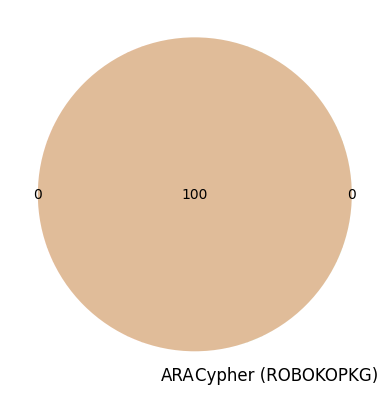

Number of common pathways: 100
Number pathways in ARA alone: 0
Number pathways in Cypher (ROBOKOPKG) alone: 0


,ARA,Cypher (ROBOKOPKG)


,ARA,Cypher (ROBOKOPKG)


ValueError: max() arg is an empty sequence

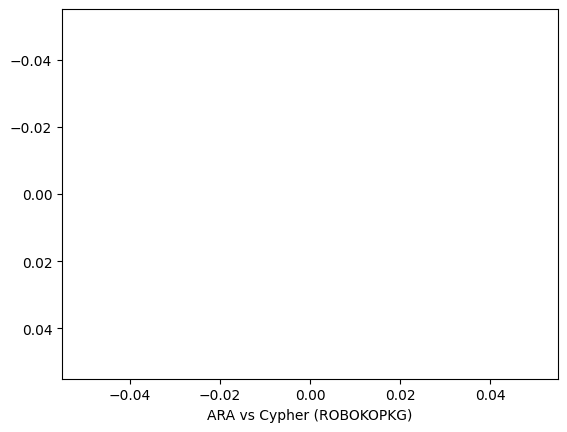

In [33]:
# ARA and "complete" Cypher (robokopkg) sets
output_file_name = os.path.join(write_dir_compare,"compare_ara_vs_cypher-robokopkg-complete.txt")
compare_results(results_df_ARA,results_df_Cypher_ROBOKOPKG_missing, output_file_name, "ARA", "Cypher (ROBOKOPKG)")